In [7]:
import sys
sys.dont_write_bytecode = True
import pandas as pd
import pickle
import bz2
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import numpy as np
import marshal
import time

In [2]:
from docker_agent_logger.app.src.AI import *

Using TensorFlow backend


In [3]:
vocab_size = 4000
max_len=60
epochs=32
chkpt = "docker_agent_logger/app/classifier/"

raw_ds = ( #.filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    tf.data.TextLineDataset("persistent_volume/data/HDFS_v2/node_logs/hadoop-hdfs-datanode-mesos-01.log")
    # .batch(128)
    # .shuffle(buffer_size=256)
)

# vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
#             raw_ds,
#             vocabulary_size=vocab_size,
#             reserved_tokens=["[PAD]", "[UNK]", "[BOS]","[EOS]"],
#         )

# with open("docker_agent_logger/app/logs_tokenizer/vocab.pkl","wb") as f:
#     pickle.dump(vocab,f)

with open("docker_agent_logger/app/logs_tokenizer/vocab.pkl","rb") as f:
    vocab = pickle.load(f)

tokenizer = Tokenizer(vocab=vocab,max_len=max_len)


ds = raw_ds.map(tokenizer.preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)


val_split = 0.2
ds_size = 2614800

train_size = int((1-val_split) * ds_size)
val_size = int(val_split * ds_size)

train_ds = ds.take(train_size).shuffle(buffer_size=train_size).batch(128)
val_ds = raw_ds.skip(train_size).take(val_size)



model = Model(vocab_size = vocab_size,latent_dim=max_len//2,embedding_dim=128,max_len = max_len)

model.vae.load_model(chkpt=chkpt+str(17))

# model.train_model(ds,epochs=epochs,chkpt=chkpt)






2023-11-20 14:34:00.104414: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22312 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:b3:00.0, compute capability: 8.6


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 60)]                 0         []                            
 )                                                                                                
                                                                                                  
 input_embedding (TokenAndP  (None, 60, 128)              519680    ['input_word_ids[0][0]']      
 ositionEmbedding)                                                                                
                                                                                                  
 encoding (TransformerEncod  (None, 60, 128)              74398     ['input_embedding[0][0]']     
 er)                                                                                        

In [48]:
from docker_agent_reader.app.src.AI_rnd import *


In [42]:
threshold = 400
anomaly_detector = AnomalyDetector(latent_space_dim=max_len//2,threshold=threshold)
data = {"logs":[],"parsed_logs":[],"vectorized_logs":[],"encoded_logs":[]}
times = {"parsed_logs":[],"vectorized_logs":[],"encoded_logs":[],"anomaly":[]}
recostruction_loss = []


for logs in val_ds.take(2000).batch(1):
    t = time.time()
    parsed_logs = tokenizer.parsing(logs)   
    t_parse = time.time()
    times["parsed_logs"].append(t_parse-t)
    vectorized_logs = tokenizer.vectorization(parsed_logs)
    t_vectorize = time.time()
    times["vectorized_logs"].append(t_vectorize-t_parse)
    encoded_logs = np.round(model.vae.encoder(vectorized_logs)[0][:,0,:]*10**5).astype(np.int32)
    t_encode = time.time()
    times["encoded_logs"].append(t_encode-t_vectorize)
    losses = model.vae.train_step(vectorized_logs,train=False)

    
    anomaly = False
    if losses["reconstruction_loss"].numpy() > threshold:
        anomaly = True
        print(f"anomaly detected with a reconstruction loss of {losses['reconstruction_loss'].numpy()}")

    t_anomaly = time.time()
    times["anomaly"].append(t_anomaly-t_encode)

    recostruction_loss.append(losses["reconstruction_loss"].numpy())


    compressed_data = bz2.compress(pickle.dumps(logs))
    data["logs"].append(sys.getsizeof(compressed_data))
    compressed_data = bz2.compress(pickle.dumps(parsed_logs))
    data["parsed_logs"].append(sys.getsizeof(compressed_data))
    compressed_data = bz2.compress(pickle.dumps(vectorized_logs))
    data["vectorized_logs"].append(sys.getsizeof(compressed_data))
    compressed_data = bz2.compress(pickle.dumps(encoded_logs))
    data["encoded_logs"].append(sys.getsizeof(compressed_data))

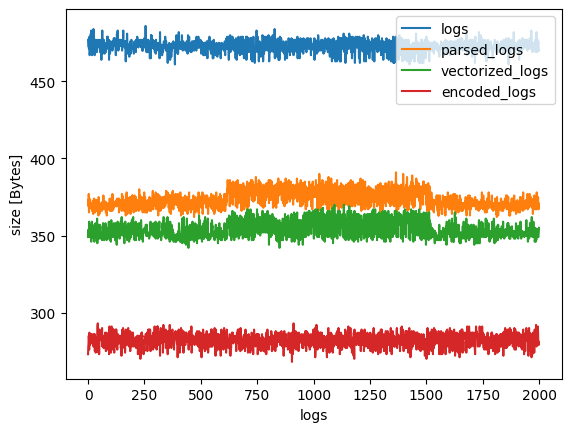

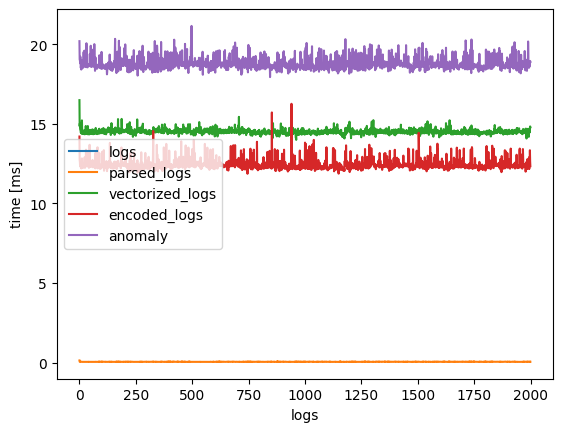

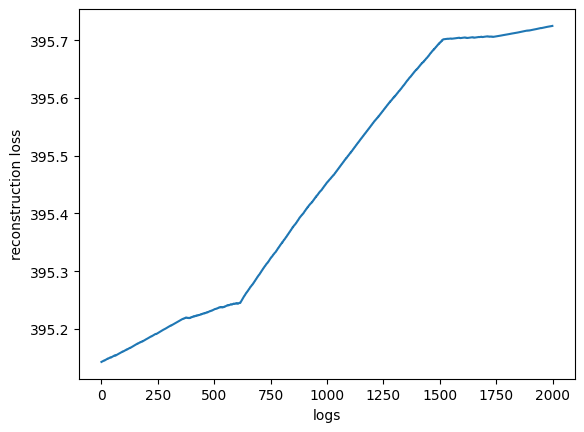

In [46]:
fig, ax = plt.subplots()
for key in data.keys():
    ax.plot(data[key], label=key)
    plt.xlabel('logs')
    plt.ylabel('size [Bytes]')
    plt.legend()

fig, ax = plt.subplots()
for key in times.keys():
    ax.plot(np.array(times[key])*10**3, label=key)
    plt.xlabel('logs')
    plt.ylabel('time [ms]')
    plt.legend()

fig, ax = plt.subplots()
ax.plot(recostruction_loss)
plt.xlabel('logs')
plt.ylabel('reconstruction loss')


plt.show()

In [ ]:
# z = tf.random.normal(shape=(1, 30),dtype=tf.float32)
encode_token = ds.take(1).as_numpy_iterator().next()[6]

print(tokenizer.decode(encode_token))

tokens = model.vae.decode(z)

print((tokenizer.decode(tokens).numpy()))


In [ ]:
def plot_label_clusters(vae, name,data):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1])
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    # plt.savefig("./results/"+name+".png")
    plt.show()

# model = Model(vocab_size = vocab_size,latent_dim=256,embedding_dim=128,max_len = max_len)


# for i in range(32):
#     model.vae.load_model(chkpt=chkpt+str(i))

#     plot_label_clusters(model.vae, "cluster"+str(i),ds)

plot_label_clusters(model.vae, "cluster"+str(17),ds.take(10000))